# BCI Signal Processing Pipeline (Filters, ICA, Wavelets)

## 1. Scenario

You are a signal processing engineer at a BCI research lab. You have received corrupted audio recordings. These recordings simulate the "Cocktail Party Problem" often found in brain data: multiple sources (instruments, voices, noise) are mixed together.

Your goal is to **deconstruct** the signal, **isolate** the voice, **clean** it, and **compress** it for transmission.

In [36]:
# Phase 1: The Spectral Splitter (Filtering)
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, filtfilt
import os
import importlib
import helper_functions
importlib.reload(helper_functions)

<module 'helper_functions' from 'c:\\Users\\ahmed_abdulhakeem\\Downloads\\fcai\\year_4\\1\\BCI\\task2\\helper_functions.py'>

In [12]:
# Load the mixed background music
data_path = 'Student_Data_Pack/mixed_background.wav'
sample_rate, audio_data = wavfile.read(data_path)

print(f"Sample Rate: {sample_rate} Hz")
print(f"Audio Shape: {audio_data.shape}")
print(f"Duration: {len(audio_data) / sample_rate:.2f} seconds")

Sample Rate: 44100 Hz
Audio Shape: (441000,)
Duration: 10.00 seconds


## Phase 1: The Spectral Splitter (Filtering)

**Objective:** Prove that `mixed_background.wav` is made of n distinct frequency bands and separate them.

### 1. Analyze
Plot the Frequency Spectrum (FFT) of the background music. You should see n distinct "blobs" of energy.

### 2. Design Filters
Create three filters using `scipy.signal` (Butterworth recommended) to recover distinct instruments.

### 3. Apply
Save the n separated audio tracks.

### Step 1.1: Load and Analyze the Data

### Step 1.2: Analyze the Frequency Spectrum

Plot the FFT to visualize the distinct frequency bands. Look for clear "blobs" of energy that represent different instruments.

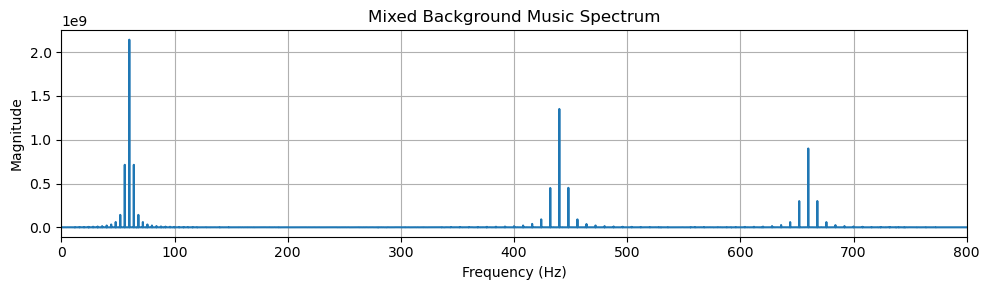

Frequency spectrum plotted. Look for distinct 'blobs' of energy.


In [13]:
# Analyze: Plot the Frequency Spectrum (FFT)
helper_functions.plot_spectrum(audio_data, sample_rate, len(audio_data), title="Mixed Background Music Spectrum", xlim=(0, 800))
print("Frequency spectrum plotted. Look for distinct 'blobs' of energy.")

### Step 1.3: Design Bandpass Filters

Create three Butterworth filters to isolate each frequency band discovered in the spectrum analysis.

In [14]:
# Filter parameters (in Hz)
bands = [
    (50, 80),      # Low frequencies
    (410, 480),    # Mid frequencies
    (620, 690)    # High frequencies
]

filters = []
order=[2, 4, 4]
for i, (lowcut, highcut) in enumerate(bands):
    b, a = helper_functions.create_bandpass_filter(sample_rate, lowcut, highcut, order=order[i])
    filters.append((b, a))

print(f"Created {len(filters)} bandpass filters")

Created 3 bandpass filters


### Step 1.4: Apply Filters and Visualize Results

Apply the filters to separate the audio tracks and visualize the original vs. separated signals.

Instrument 1 extracted: frequency range 50-80 Hz
Instrument 2 extracted: frequency range 410-480 Hz
Instrument 3 extracted: frequency range 620-690 Hz


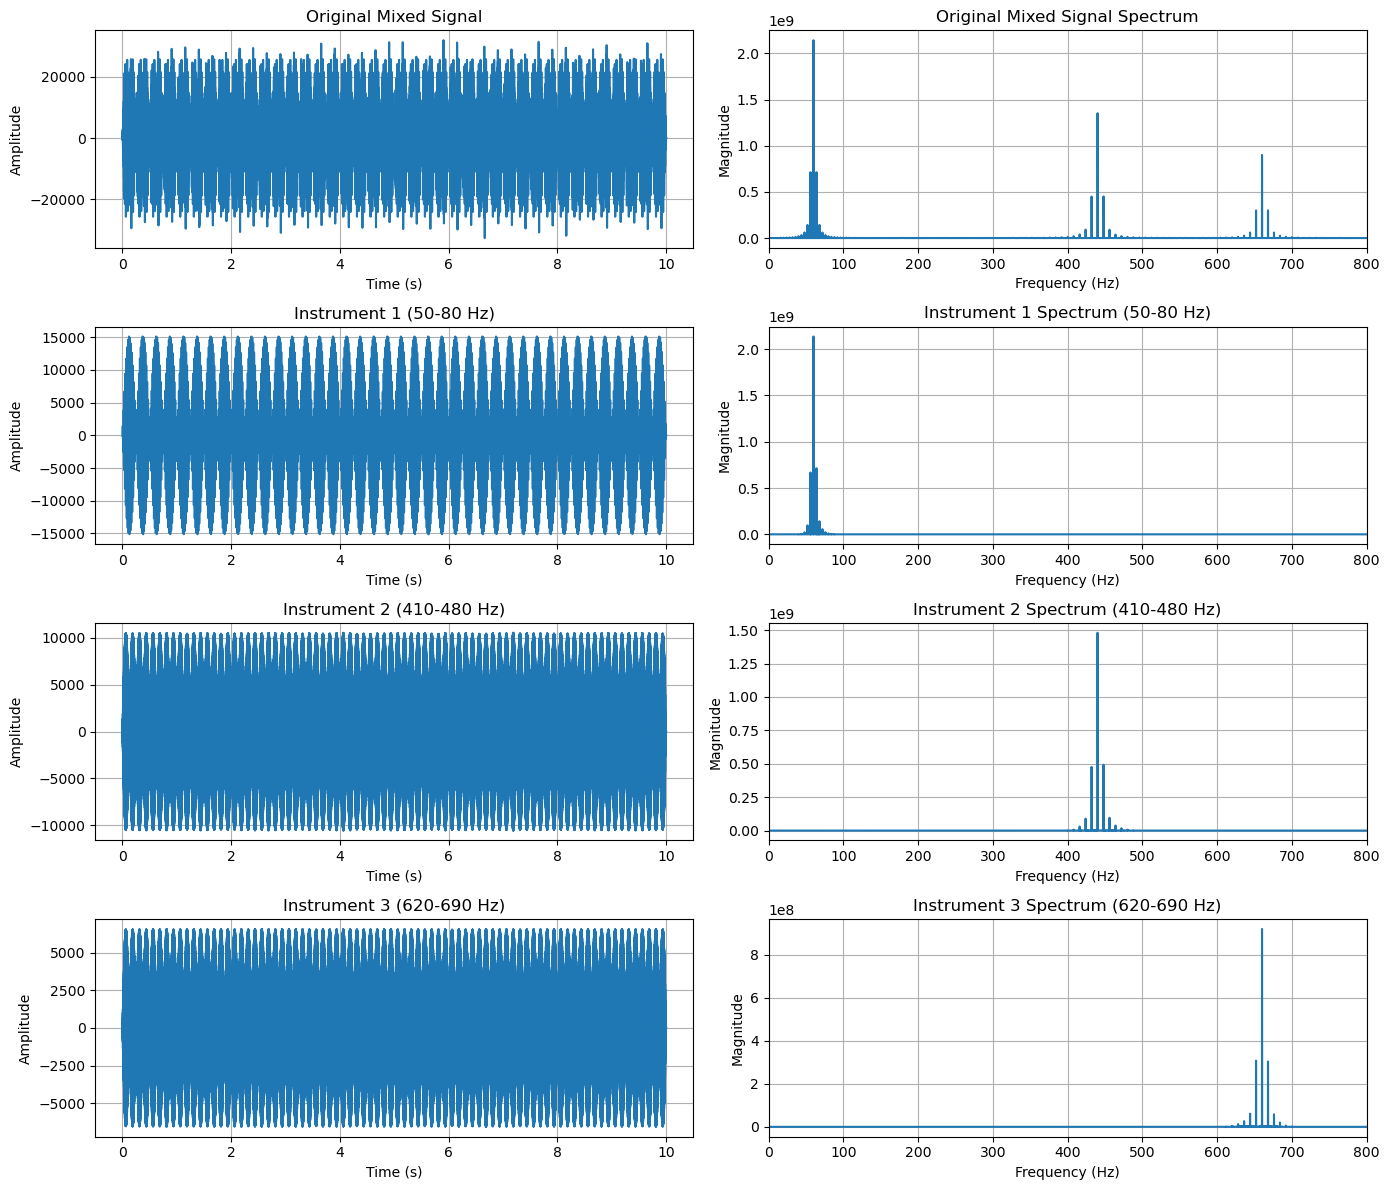

Signals separated successfully!


In [15]:
# Apply: Separate audio tracks using the filters
separated_signals = []
for i, (b, a) in enumerate(filters):
    filtered = filtfilt(b, a, audio_data)
    separated_signals.append(filtered)
    print(f"Instrument {i+1} extracted: frequency range {bands[i][0]}-{bands[i][1]} Hz")

# Verify the separation - plot original and each separated signal
fig, axes = plt.subplots(len(separated_signals) + 1, 2, figsize=(14, 12))

# Plot original signal waveform and spectrum
helper_functions.plot_waveform(audio_data, sample_rate, ax=axes[0, 0], title='Original Mixed Signal')
helper_functions.plot_spectrum(audio_data, sample_rate, n_fft=len(audio_data), ax=axes[0, 1], title='Original Mixed Signal Spectrum', xlim=(0, 800))

# Plot separated signals
for i, signal in enumerate(separated_signals):
    helper_functions.plot_waveform(signal, sample_rate, ax=axes[i+1, 0], title=f'Instrument {i+1} ({bands[i][0]}-{bands[i][1]} Hz)')
    helper_functions.plot_spectrum(signal, sample_rate, n_fft=len(signal), ax=axes[i+1, 1], title=f'Instrument {i+1} Spectrum ({bands[i][0]}-{bands[i][1]} Hz)', xlim=(0, 800))

plt.tight_layout()
plt.show()

print("Signals separated successfully!")

### Step 1.5: Save Separated Audio Tracks

Save each separated instrument as an individual audio file for verification and use in later phases.

In [16]:
# Save the separated audio tracks
output_dir = 'Student_Data_Pack'
os.makedirs(output_dir, exist_ok=True)

for i, signal in enumerate(separated_signals):
    # Normalize to prevent clipping
    signal = np.int16(signal / np.max(np.abs(signal)) * 32767)
    output_file = os.path.join(output_dir, f'instrument_{i+1}.wav')
    wavfile.write(output_file, sample_rate, signal)
    print(f"Saved: {output_file}")

print("\nPhase 1 Complete! All separated audio tracks have been saved.")

Saved: Student_Data_Pack\instrument_1.wav
Saved: Student_Data_Pack\instrument_2.wav
Saved: Student_Data_Pack\instrument_3.wav

Phase 1 Complete! All separated audio tracks have been saved.


## Phase 2: The Cocktail Party (ICA)

**Objective:** Separate the "Voice" from the "Background Music" using Blind Source Separation.

1. Construction: Load `Student_Data_Pack/mic_1.wav` and `Student_Data_Pack/mic_2.wav` and assemble them into an appropriate data matrix (rows = channels, columns = samples).
2. Separation: Apply a Blind Source Separation algorithm such as `FastICA` (from `sklearn.decomposition` or `mne.preprocessing`) to recover the independent sources.
3. Recover: Identify which recovered component corresponds to the voice and which corresponds to the music. Save the two output signals (e.g., `source_1.wav` and `source_2.wav`) and listen to them to verify.

Notes:
- If the ICA outputs are scaled or sign-flipped, align their amplitude and sign before saving.
- Visual inspection (waveforms and short-time spectra) can help choose the voice component.

In [17]:
# Load the mixed background music
mic1 = 'Student_Data_Pack/mic_1.wav'
mic1_sr, mic1_d = wavfile.read(mic1)

print(f"Sample Rate: {mic1_sr} Hz")
print(f"Audio Shape: {mic1_d.shape}")
print(f"Duration: {len(mic1_d) / mic1_sr:.2f} seconds")

Sample Rate: 44100 Hz
Audio Shape: (441000,)
Duration: 10.00 seconds


In [18]:
# Load the mixed background music
mic2 = 'Student_Data_Pack/mic_2.wav'
mic2_sr, mic2_d = wavfile.read(mic2)

print(f"Sample Rate: {mic2_sr} Hz")
print(f"Audio Shape: {mic2_d.shape}")
print(f"Duration: {len(mic2_d) / mic2_sr:.2f} seconds")

Sample Rate: 44100 Hz
Audio Shape: (441000,)
Duration: 10.00 seconds


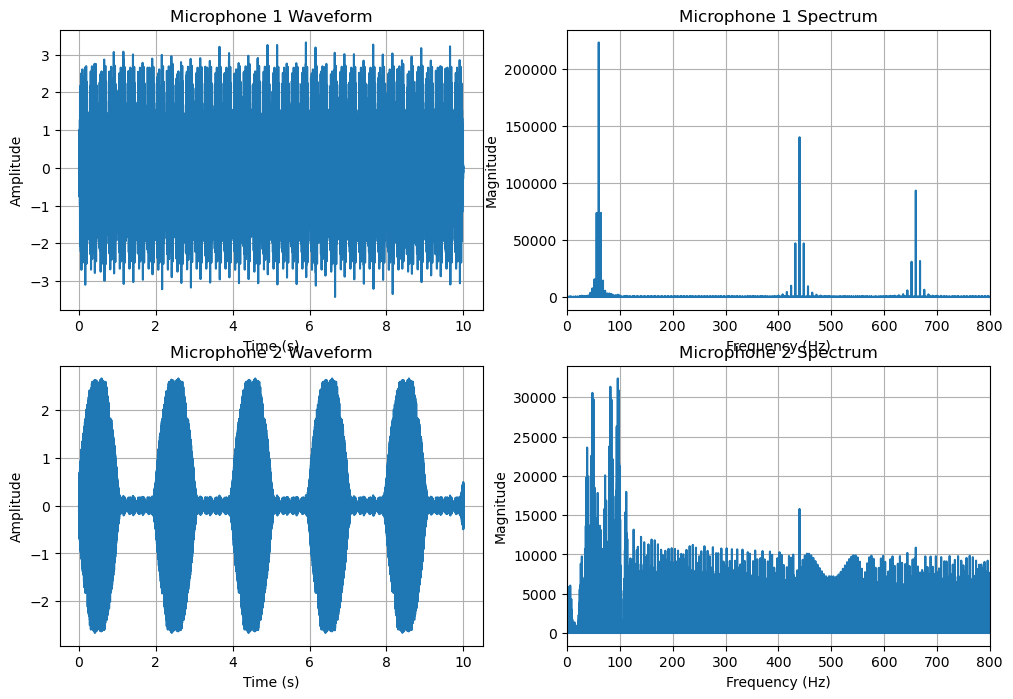

In [19]:
from sklearn.decomposition import FastICA

X = np.c_[mic1_d, mic2_d]

ica = FastICA(n_components=2)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
helper_functions.plot_waveform(S_[:, 0], mic1_sr, ax=axes[0, 0], title='Microphone 1 Waveform')
helper_functions.plot_spectrum(S_[:, 0], mic1_sr, n_fft=len(S_[:, 0]), ax=axes[0, 1], title='Microphone 1 Spectrum', xlim=(0, 800))
helper_functions.plot_waveform(S_[:, 1], mic2_sr, ax=axes[1, 0], title='Microphone 2 Waveform')
helper_functions.plot_spectrum(S_[:, 1], mic2_sr, n_fft=len(S_[:, 1]), ax=axes[1, 1], title='Microphone 2 Spectrum', xlim=(0, 800))

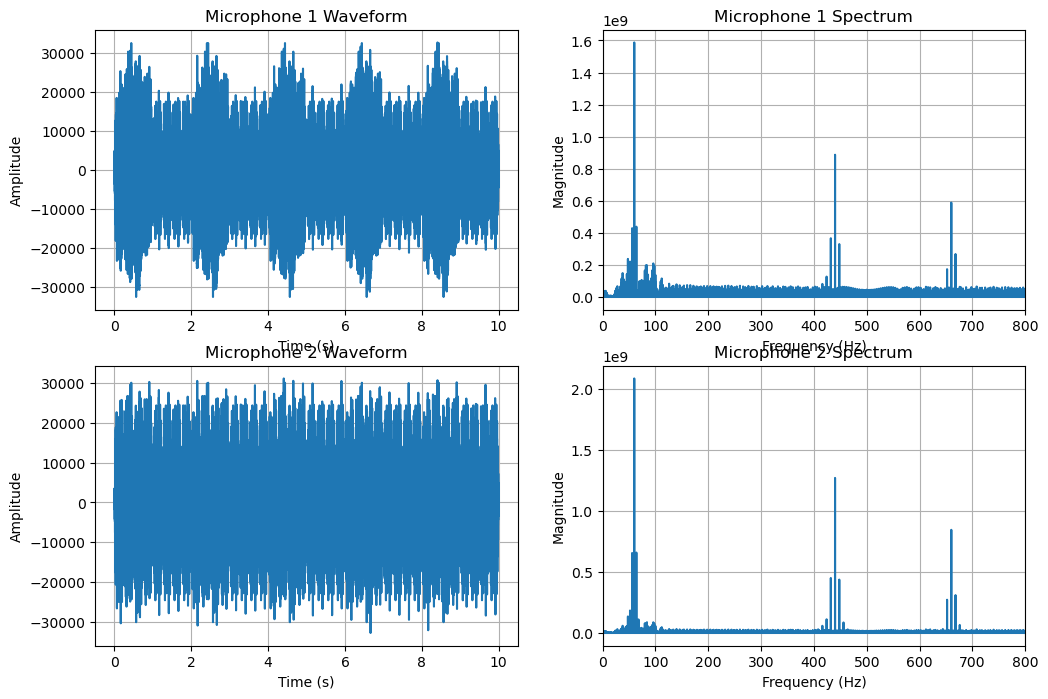

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

helper_functions.plot_waveform(mic1_d, mic1_sr, ax=axes[0, 0], title='Microphone 1 Waveform')
helper_functions.plot_spectrum(mic1_d, mic1_sr, n_fft=len(mic1_d), ax=axes[0, 1], title='Microphone 1 Spectrum', xlim=(0, 800))

helper_functions.plot_waveform(mic2_d, mic2_sr, ax=axes[1, 0], title='Microphone 2 Waveform')
helper_functions.plot_spectrum(mic2_d, mic2_sr, n_fft=len(mic2_d), ax=axes[1, 1], title='Microphone 2 Spectrum', xlim=(0, 800))

In [21]:
# Save the separated audio tracks
output_dir = 'task2_output'
os.makedirs(output_dir, exist_ok=True)

for i in range(S_.shape[1]):
    signal = S_[:, i]
    # Normalize to prevent clipping
    signal = np.int16(signal / np.max(np.abs(signal)) * 32767)
    output_file = os.path.join(output_dir, f'ica_instrument_{i+1}.wav')
    wavfile.write(output_file, mic1_sr, signal)
    print(f"Saved: {output_file}")

Saved: task2_output\ica_instrument_1.wav
Saved: task2_output\ica_instrument_2.wav


## Phase 2B: The Clean-Up (Post-Processing)

**Objective:** Polish the ICA result by applying a frequency filter to the chosen voice component to remove residual noise and rumble.

1. Select: From the two ICA outputs, identify which signal is the voice (listen and inspect spectrograms).
2. Filter: Design a frequency filter (e.g., high-pass to remove subsonic rumble, low-pass to remove high-frequency noise) using `scipy.signal`.
3. Apply: Filter the chosen voice track and compare before/after spectrograms to verify improvement.
4. Save: Export the cleaned result as `clean_voice.wav` for use in the compression phase.

Notes:
- Use zero-phase filtering (`filtfilt`) to avoid phase distortion when preserving speech intelligibility.
- Keep a copy of the unfiltered ICA output for comparison and reproducibility.

Phase 2B: The Clean-Up (Post-Processing)

Analyzing ICA outputs...
music Output 1 - Duration: 10.00 seconds
voice Output 2 - Duration: 10.00 seconds


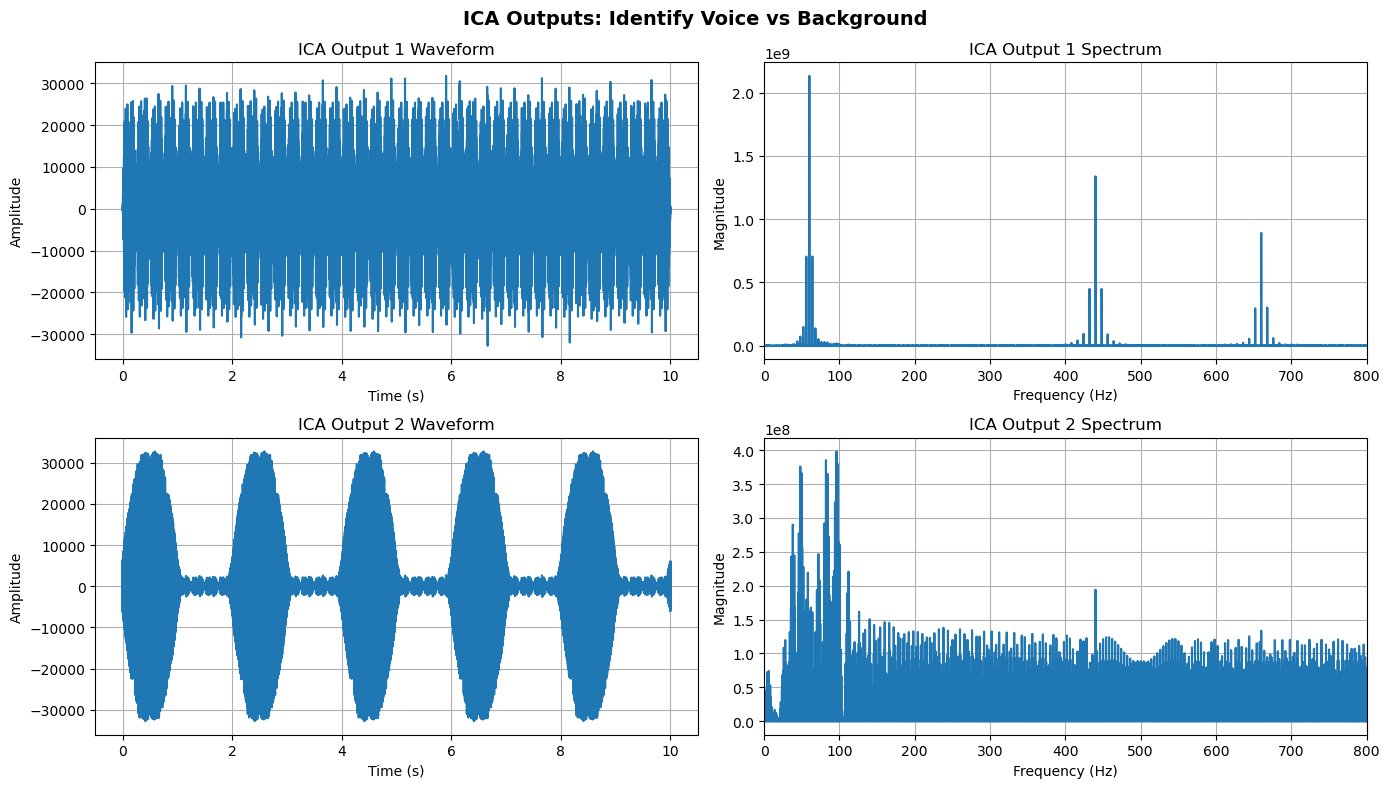


Inspection Guide:
- Voice typically shows energy in 100-4000 Hz range with distinct harmonic structure
- Background music typically has more continuous, broader frequency distribution

Based on visual inspection, we'll use ICA Output 1 as the voice component

Selected: ICA Output 2 as voice component


In [22]:
# Phase 2B: Load and Analyze ICA Outputs to Select Voice Component
print("Phase 2B: The Clean-Up (Post-Processing)")
print("=" * 50)

# Load the two ICA outputs from the saved files
output_dir = 'task2_output'
music_sr, music_signal = wavfile.read(os.path.join(output_dir, 'ica_instrument_1.wav'))
voice_sr, voice_signal = wavfile.read(os.path.join(output_dir, 'ica_instrument_2.wav'))

    
# Visualize both ICA outputs to identify which is the voice
print("\nAnalyzing ICA outputs...")
print(f"music Output 1 - Duration: {len(music_signal) / music_sr:.2f} seconds")
print(f"voice Output 2 - Duration: {len(voice_signal) / voice_sr:.2f} seconds")

# Plot waveforms and spectra of both ICA outputs
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

helper_functions.plot_waveform(music_signal, music_sr, ax=axes[0, 0], title='ICA Output 1 Waveform')
helper_functions.plot_spectrum(music_signal, music_sr, n_fft=len(music_signal), ax=axes[0, 1],
                               title='ICA Output 1 Spectrum', xlim=(0, 800))

helper_functions.plot_waveform(voice_signal, voice_sr, ax=axes[1, 0], title='ICA Output 2 Waveform')
helper_functions.plot_spectrum(voice_signal, voice_sr, n_fft=len(voice_signal), ax=axes[1, 1],
                               title='ICA Output 2 Spectrum', xlim=(0, 800))

plt.suptitle('ICA Outputs: Identify Voice vs Background', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInspection Guide:")
print("- Voice typically shows energy in 100-4000 Hz range with distinct harmonic structure")
print("- Background music typically has more continuous, broader frequency distribution")
print("\nBased on visual inspection, we'll use ICA Output 1 as the voice component")

# Select the voice component (ICA Output 1)
voice_ica = voice_signal
voice_sr = voice_sr
print(f"\nSelected: ICA Output 2 as voice component")

Step 1: Design Filters
High-pass filter: 80 Hz, order 4
Low-pass filter: 4000 Hz, order 4

Step 2: Apply Filters Z(Zero-Phase using filtfilt)
Applied high-pass filter to remove subsonic rumble
Applied low-pass filter to remove high-frequency noise

Step 3: Compare Before and After Cleaning


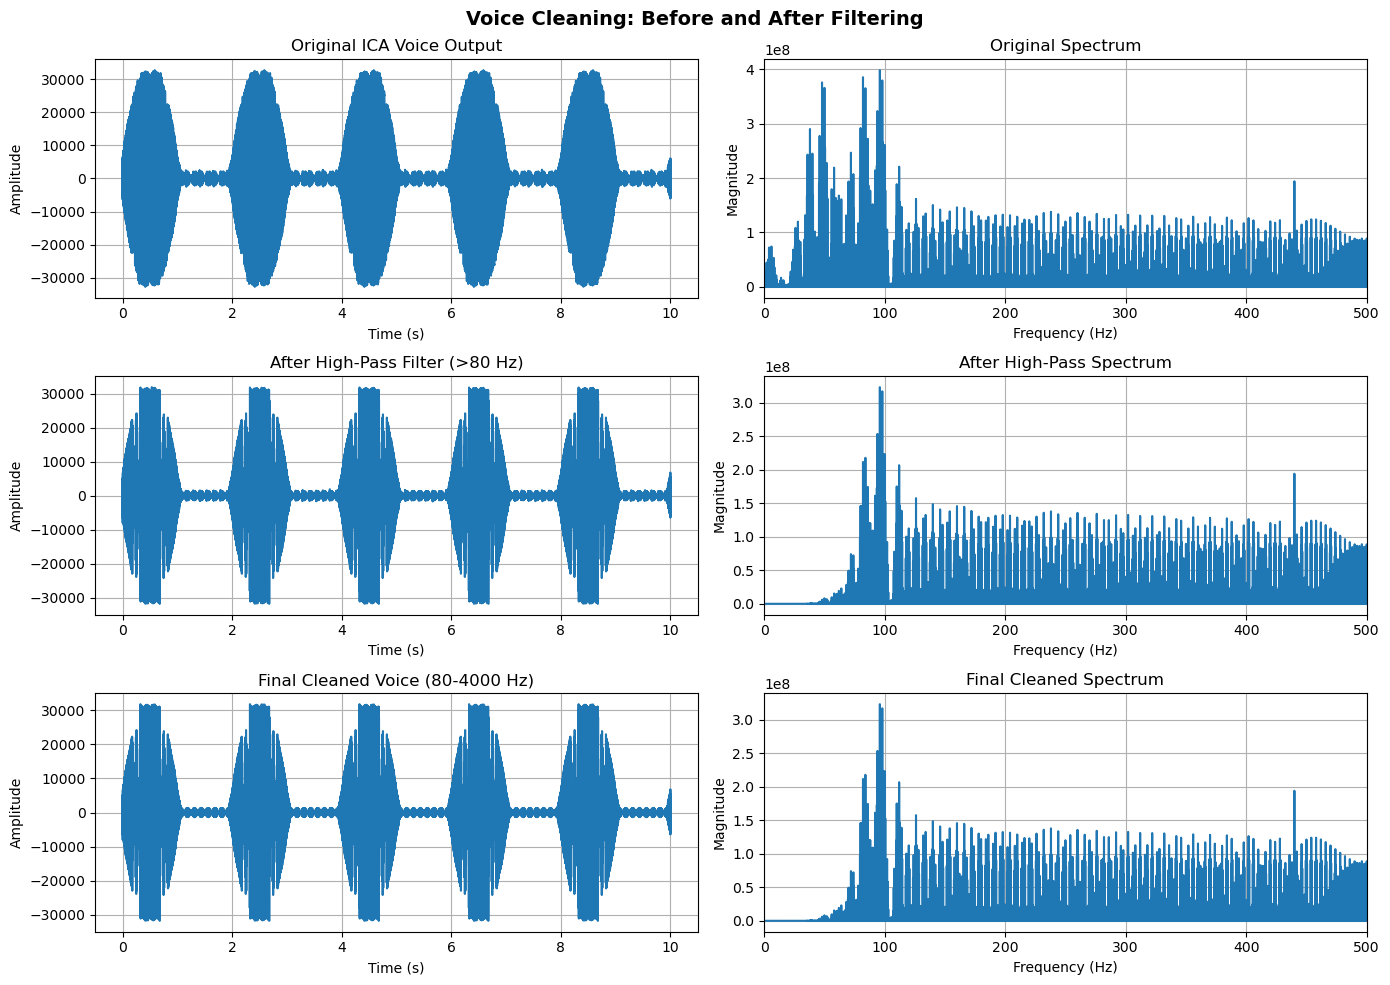

Cleaning comparison plots generated successfully!


In [23]:
# Design and Apply Filters to Clean the Voice
from scipy.signal import butter, filtfilt

print("Step 1: Design Filters")
print("=" * 50)

# Design high-pass filter to remove subsonic rumble (below ~80 Hz)
hp_cutoff = 80  # Hz
hp_order = 4
b_hp, a_hp = helper_functions.create_bandpass_filter(voice_sr, hp_cutoff, voice_sr // 2 - 100, order=hp_order)

# Instead, let's use a proper high-pass filter
b_hp, a_hp = butter(hp_order, hp_cutoff / (voice_sr / 2), btype='high')
print(f"High-pass filter: {hp_cutoff} Hz, order {hp_order}")

# Design low-pass filter to remove high-frequency noise (above ~4000 Hz)
lp_cutoff = 4000  # Hz
lp_order = 4
b_lp, a_lp = butter(lp_order, lp_cutoff / (voice_sr / 2), btype='low')
print(f"Low-pass filter: {lp_cutoff} Hz, order {lp_order}")

print("\nStep 2: Apply Filters Z(Zero-Phase using filtfilt)")
print("=" * 50)

# Apply high-pass filter with zero-phase filtering
voice_hp = filtfilt(b_hp, a_hp, voice_ica)
print("Applied high-pass filter to remove subsonic rumble")

# Apply low-pass filter with zero-phase filtering
voice_cleaned = filtfilt(b_lp, a_lp, voice_hp)
print("Applied low-pass filter to remove high-frequency noise")

print("\nStep 3: Compare Before and After Cleaning")
print("=" * 50)

# Create comparison plots
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Original ICA voice output
helper_functions.plot_waveform(voice_ica, voice_sr, ax=axes[0, 0], title='Original ICA Voice Output')
helper_functions.plot_spectrum(voice_ica, voice_sr, n_fft=len(voice_ica), ax=axes[0, 1], 
                               title='Original Spectrum', xlim=(0, 500))

# After high-pass filter
helper_functions.plot_waveform(voice_hp, voice_sr, ax=axes[1, 0], title='After High-Pass Filter (>80 Hz)')
helper_functions.plot_spectrum(voice_hp, voice_sr, n_fft=len(voice_hp), ax=axes[1, 1], 
                               title='After High-Pass Spectrum', xlim=(0, 500))

# Final cleaned voice
helper_functions.plot_waveform(voice_cleaned, voice_sr, ax=axes[2, 0], title='Final Cleaned Voice (80-4000 Hz)')
helper_functions.plot_spectrum(voice_cleaned, voice_sr, n_fft=len(voice_cleaned), ax=axes[2, 1], 
                               title='Final Cleaned Spectrum', xlim=(0, 500))

plt.suptitle('Voice Cleaning: Before and After Filtering', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Cleaning comparison plots generated successfully!")


In [24]:
# Save Cleaned Voice and Unfiltered Copy for Reproducibility
print("Step 4: Save Cleaned Voice Output")
print("=" * 50)

# Normalize cleaned voice to prevent clipping
voice_cleaned_normalized = np.int16(voice_cleaned / np.max(np.abs(voice_cleaned)) * 32767)

# Save the cleaned voice
output_dir = 'task2_output'
os.makedirs(output_dir, exist_ok=True)

clean_voice_path = os.path.join(output_dir, 'clean_voice.wav')
wavfile.write(clean_voice_path, voice_sr, voice_cleaned_normalized)
print(f"\n✓ Saved: {clean_voice_path}")

# Also save the unfiltered ICA output for reproducibility
unfiltered_path = os.path.join(output_dir, 'voice_ica_unfiltered.wav')
voice_ica_normalized = np.int16(voice_ica / np.max(np.abs(voice_ica)) * 32767)
wavfile.write(unfiltered_path, voice_sr, voice_ica_normalized)
print(f"✓ Saved: {unfiltered_path}")

print("\n" + "=" * 50)
print("Phase 2B Complete: Voice Cleaning and Post-Processing")
print("=" * 50)
print(f"\nSummary:")
print(f"- Original ICA voice component: {len(voice_ica)} samples")
print(f"- Cleaned voice output: {len(voice_cleaned)} samples")
print(f"- Filters applied: High-pass (80 Hz) + Low-pass (4000 Hz)")
print(f"- Zero-phase filtering (filtfilt) preserved speech intelligibility")
print(f"\nOutput files:")
print(f"  1. clean_voice.wav - Ready for compression phase")
print(f"  2. voice_ica_unfiltered.wav - Original for reproducibility")


Step 4: Save Cleaned Voice Output

✓ Saved: task2_output\clean_voice.wav
✓ Saved: task2_output\voice_ica_unfiltered.wav

Phase 2B Complete: Voice Cleaning and Post-Processing

Summary:
- Original ICA voice component: 441000 samples
- Cleaned voice output: 441000 samples
- Filters applied: High-pass (80 Hz) + Low-pass (4000 Hz)
- Zero-phase filtering (filtfilt) preserved speech intelligibility

Output files:
  1. clean_voice.wav - Ready for compression phase
  2. voice_ica_unfiltered.wav - Original for reproducibility


## Phase 3: The Bit-Crusher (Wavelet Compression)

**Objective:** Compress the cleaned voice track to save bandwidth while retaining intelligibility.

1. Decompose: Load `clean_voice.wav` and perform a Discrete Wavelet Transform (DWT) — e.g., level 5 with `'db4'` wavelet — to obtain wavelet coefficients.
2. Threshold: Sort coefficients by magnitude and keep only the top X% (for example, top 20%) — set the rest to zero to achieve compression.
3. Reconstruct: Perform the Inverse DWT using the thresholded coefficients to obtain the compressed audio signal.
4. Analysis: Calculate the compression ratio (size of retained coefficients vs original) and listen to the result to assess quality.

Notes:
- Experiment with the percentage of coefficients retained to find a balance between compression and perceptual quality.
- Consider storing coefficient indices and values efficiently (e.g., run-length or sparse serialization) for real compression tasks.

Loaded 'task2_output\compressed_voice_20pct.wav', 441000 samples, sr=44100 Hz. Normalized.
Total coeffs: 441,034. Retaining top 88,207 (20.0%).
Threshold magnitude = 9.853375e-04
Kept coefficients: 88,207 / 441,034 -> retained ratio = 0.2000
MSE (normalized signals) = 2.715906e-08, approx SNR = 66.37 dB
Saved compressed audio to 'compressed_voice.wav'


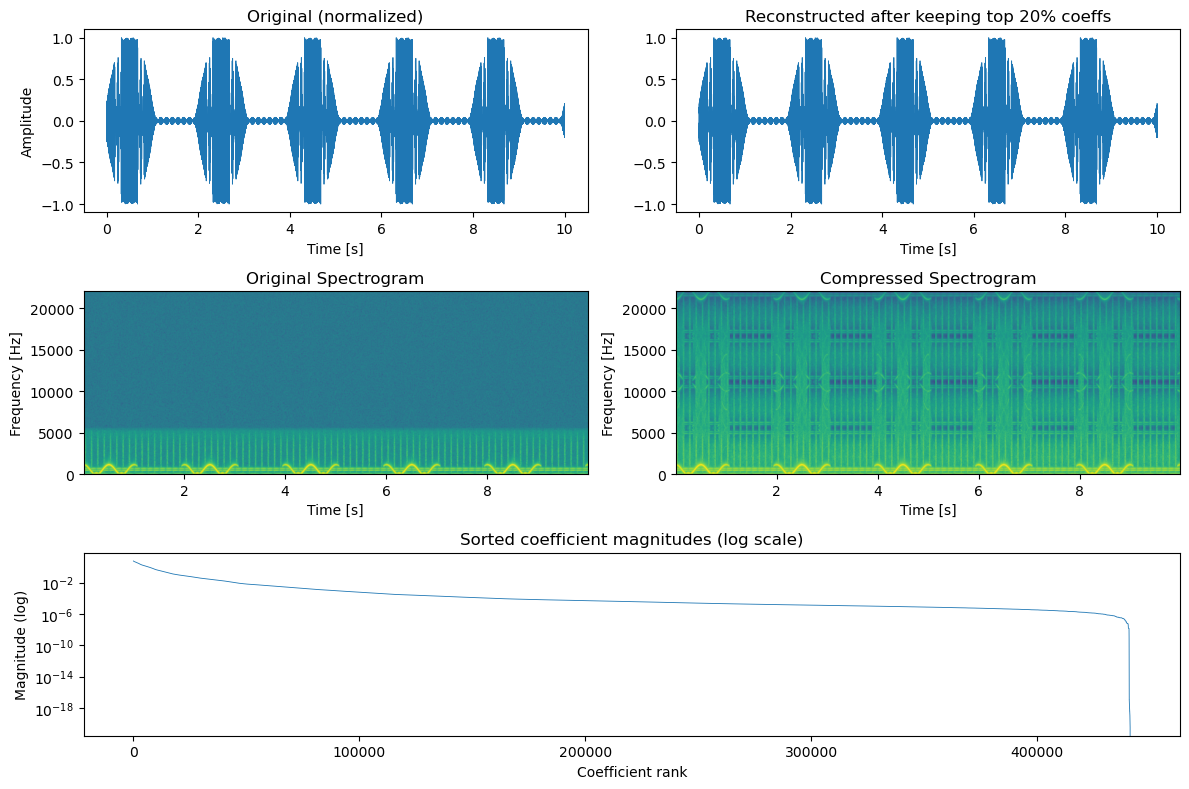

Sparse representation example: 88207 nonzero coefficients stored.


In [38]:
import soundfile as sf
import pywt
from scipy import fftpack

# -------- Parameters --------
wav_path = "task2_output\\compressed_voice_20pct.wav"      # input (make sure file exists)
out_path = "compressed_voice.wav" # output file
wavelet = 'db4'
level = 5
retain_ratio = 0.20               # keep top 20% coefficients by magnitude (change to taste)
dtype_out = 'float32'             # saved dtype (float32 is fine for listening)
# ----------------------------

# ---- helper: compute spectrogram (for visualization) ----
def plot_spectrogram(ax, sig, sr, title):
    ax.specgram(sig, NFFT=1024, Fs=sr, noverlap=512, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')

# ---- load audio ----
sig, sr = sf.read(wav_path)
if sig.ndim > 1:
    # if stereo, mix to mono (or choose a channel)
    sig = sig.mean(axis=1)
sig = np.asarray(sig, dtype=float)

# normalize to avoid crazy numeric ranges
maxv = np.max(np.abs(sig))
if maxv == 0:
    raise ValueError("Input signal is silent.")
sig = sig / maxv

print(f"Loaded '{wav_path}', {len(sig)} samples, sr={sr} Hz. Normalized.")

# ---- DWT decomposition ----
# pywt.wavedec returns [cA_n, cD_n, cD_{n-1}, ..., cD1]
coeffs = pywt.wavedec(sig, wavelet=wavelet, level=level)
# flatten coefficients to a single vector (for global thresholding)
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

n_coeff = coeff_arr.size
n_keep = int(np.ceil(retain_ratio * n_coeff))
print(f"Total coeffs: {n_coeff:,}. Retaining top {n_keep:,} ({retain_ratio*100:.1f}%).")

# ---- thresholding: keep top-k by magnitude ----
abs_arr = np.abs(coeff_arr)
# find threshold value (value of the k-th largest coefficient)
if n_keep < 1:
    threshold = np.inf
else:
    # partition to find k-th largest quickly
    kth = np.partition(abs_arr.flatten(), -n_keep)[-n_keep]
    threshold = kth
print(f"Threshold magnitude = {threshold:.6e}")

# zero out coefficients below threshold
mask = abs_arr >= threshold
coeff_thresh = coeff_arr * mask

# ---- reconstruct coefficient list and signal ----
coeffs_thresh = pywt.array_to_coeffs(coeff_thresh, coeff_slices, output_format='wavedec')
sig_rec = pywt.waverec(coeffs_thresh, wavelet=wavelet)

# waverec may produce slightly different length -> trim/pad
sig_rec = sig_rec[:len(sig)]

# renormalize amplitude to original scale (and avoid clipping)
# scale back using maxv to have same peak as input (optional)
sig_rec = sig_rec * maxv

# ---- compute simple quality metrics ----
# compression ratio = kept coefficients / total coefficients (or bytes if serialized)
ratio = mask.sum() / n_coeff
mse = np.mean((sig - sig_rec / maxv)**2)   # compare normalized signals
if mse == 0:
    snr_db = np.inf
else:
    snr_db = 10 * np.log10(np.mean(sig**2) / mse)

print(f"Kept coefficients: {mask.sum():,} / {n_coeff:,} -> retained ratio = {ratio:.4f}")
print(f"MSE (normalized signals) = {mse:.6e}, approx SNR = {snr_db:.2f} dB")

# ---- save compressed audio ----
# ensure no clipping before saving: normalize if necessary
max_rec = np.max(np.abs(sig_rec))
if max_rec > 1.0:
    sig_rec_out = (sig_rec / max_rec) * 0.99
else:
    sig_rec_out = sig_rec

sf.write(out_path, sig_rec_out.astype(dtype_out), sr)
print(f"Saved compressed audio to '{out_path}'")

# ---- plots ----
fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot2grid((3,2), (0,0), colspan=1)
ax2 = plt.subplot2grid((3,2), (0,1))
ax3 = plt.subplot2grid((3,2), (1,0))
ax4 = plt.subplot2grid((3,2), (1,1))
ax5 = plt.subplot2grid((3,2), (2,0), colspan=2)

t = np.arange(len(sig))/sr

ax1.plot(t, sig, linewidth=0.6)
ax1.set_title("Original (normalized)")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Amplitude")

ax2.plot(t, sig_rec_out / (np.max(np.abs(sig_rec_out)) + 1e-16), linewidth=0.6)
ax2.set_title(f"Reconstructed after keeping top {retain_ratio*100:.0f}% coeffs")
ax2.set_xlabel("Time [s]")

plot_spectrogram(ax3, sig, sr, "Original Spectrogram")
plot_spectrogram(ax4, sig_rec_out, sr, "Compressed Spectrogram")

# coefficient magnitude histogram / visualization
ax5.plot(np.sort(np.abs(coeff_arr))[::-1], linewidth=0.6)
ax5.set_yscale('log')
ax5.set_title("Sorted coefficient magnitudes (log scale)")
ax5.set_xlabel("Coefficient rank")
ax5.set_ylabel("Magnitude (log)")

plt.tight_layout()
plt.show()

# ---- extra: save sparse representation (indices + values) example ----
# This is how real compression could be saved: indices of kept coeffs + values + coeff_slices
kept_indices = np.nonzero(mask)[0]
kept_values = coeff_thresh[kept_indices]
# You would store kept_indices, kept_values, coeff_slices and wavelet/level metadata.
print(f"Sparse representation example: {kept_indices.size} nonzero coefficients stored.")
